- 2nd try 코드 중 customdataset 클래스에서 flatten 부분 하지 않고 손수 다운로드한 데이터 이용
- 7th try model 적용
- 4th try의 train loss 시각화 가져옴. 시각화 위해 7th try의 train 부분 수정

[model 참고](https://velog.io/@y30n9ju1v/Pytorch-%EA%B0%84%EB%8B%A8%ED%95%9C-CNN%EC%9C%BC%EB%A1%9C-MNIST-%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0)

## Library import

In [1]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt

import gzip
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 이미지 추출, 이미지 출력, 라벨 list 생성 함수
[함수 인자 입력 순서](https://naon.me/posts/til18)

In [2]:
def extract_imgs(n, train = True):
    if train:
        imgs = gzip.open("train-images-idx3-ubyte.gz", 'r')
    else:
        imgs = gzip.open("t10k-images-idx3-ubyte.gz", 'r')
    
    img_size = 28
    num_imgs = n
    
    imgs.read(16) # 꼭 있어야 하는 코드였다. 출력을 위한게 아니었음.
    
    buf = imgs.read(img_size * img_size * num_imgs)
    data = np.frombuffer(buf, dtype = np.uint8).astype(np.float32)
    data = data.reshape(num_imgs, img_size, img_size, 1)
    
    return data

def print_imgs(data, idx):
    img = np.asarray(data[idx]).squeeze()
    plt.imshow(img)
    plt.show()

def label_li(fin, train = True):
    li = []
    
    if train:
        labels = gzip.open("train-labels-idx1-ubyte.gz", 'r')
    else:
        labels = gzip.open("t10k-labels-idx1-ubyte.gz", 'r')
    
    labels.read(8) # 꼭 있어야 하는 코드였다. 출력을 위한게 아니었음.
    
    for i in range(0, fin): # start 늘린 수 만큼 뒤쪽 출력이 안됨.
        buf = labels.read(1)
        label = np.frombuffer(buf, dtype = np.uint8).astype(np.int64)
        li.extend(list(label))
        
    return li

## 환경설정

In [ ]:
import torch
import torch.nn as nn
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID' # Arrange GPU devices starting from 0
os.environ['CUDA_VISIBLE_DEVICES'] = '2' # Set the GPU 2 to use
# 멀티 gpu 시스템은 하나의 GPU에서 코드가 실행되게 프로그래밍을 해도 모든 GPU에 메모리를 할당함.
# 따라서 2번 gpu만 사용하도록 코드를 짜 준 것.
## 돌아가는 것 확인 함.

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
#GPU 체크 및 할당
if torch.cuda.is_available():    
    #device = torch.device("cuda:0")
    print('Device:', device)
    print('Current cuda device:', torch.cuda.current_device()) # 현재 cuda가 사용할 GPU
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

## 하이퍼파라미터 튜닝

In [ ]:
CFG = {
    'IMG_SIZE':28, #이미지 사이즈
    'EPOCHS':50, #에포크
    'LEARNING_RATE':1e-5, #학습률
    'BATCH_SIZE':32, #배치사이즈
    'SEED':41, #시드
}

### 모델의 재현성을 위한 random seed 고정

In [ ]:
# Seed 고정
import random
import numpy as np

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 랜덤시드 고정
    torch.cuda.manual_seed(seed) # gpu 사용할 경우 랜덤시드 고정
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(CFG['SEED'])

In [ ]:
numdat = 10000
data = extract_imgs(numdat)
labels = label_li(numdat)

## train/val split

In [8]:
train_len = int(len(data)*0.75)
val_len = int(len(data)*0.25)

# train_data = data[:train_len]
# train_label = labels[:train_len]

# val_data = data[train_len:]
# val_label = labels[train_len:]

print('train set 길이 : ', train_len)
print('vaildation set 길이 : ', val_len)

train set 길이 :  7500
vaildation set 길이 :  2500


## validation set

In [9]:
val_dt = data[train_len:]
val_lb = labels[train_len:]

In [10]:
## test cell
torch.tensor(val_dt.reshape(len(val_dt), 1, 28, 28)).float().shape

torch.tensor(val_lb)

torch.Size([2500, 1, 28, 28])

tensor([2, 3, 4,  ..., 6, 9, 7])

## test set

In [24]:
numdat = 10000
test_data = extract_imgs(numdat, train = False)
test_labels = label_li(numdat, train = False)

In [11]:
# data

## Custom Dataset

In [12]:
from torchvision import datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import DataLoader, Dataset

import cv2

class CustomDataset(Dataset):
    def __init__(self, img_list, label_list, train_mode = True, transforms = None): # 필요한 변수들을 선언
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_list = img_list
        self.label_list = label_list
    
    def __getitem__(self, index): # index번째 data를 return
        img = self.img_list[index]
        img = np.asarray(data[index]).squeeze() # 추가해준 처리
        ## Get image data
#         print(img_path)
#         image = cv2.imread(img) # 이미 읽어온 이미지라서 이 코드 필요 없음.
#         print(image) # numpy 배열
        
        if self.transforms is not None:
            img = self.transforms(img)
            #flattened_img = img.flatten().float() # 2차원 이미지를 1차원으로 변환
        
        if self.train_mode:
            label = self.label_list[index]
            return img, label
        else:
            return img
        
    def __len__(self): # 길이 return
        return len(self.img_list)

## transform

In [13]:
train_transform = transforms.Compose([
    transforms.ToPILImage(), # Numpy arr에서 PIL 이미지로
#     transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]), # 이미지 사이즈 변형
    transforms.ToTensor()#, # 이미지 데이터를 tensor로
#     transforms.Normalize(mean = (0.5,), std = (0.5,)) # 이미지 정규화 (원소 3개짜리는 색이 있는 이미지일 경우에만, MNIST는 색 없는 이미지이므로 사용하지 않음.)
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
#     transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]), # size 다 동일하므로 resize는 필요 없음
    transforms.ToTensor()#,
#     transforms.Normalize(mean = (0.5,), std = (0.5,)) ## 채널 별 정규화 (원소 3개짜리는 색이 있는 이미지일 경우에만, MNIST는 색 없는 이미지이므로 사용하지 않음.)
])

In [14]:
# image = Image.open(self.file_path_list[idx]) # 해당 인덱스에 맞는 image 추출
#         tensor_image = self.PIL2tensor(image) # PIL로 읽은 이미지를 torch tensor형으로 변환
#         flattened_image = tensor_image.flatten().float()

## dataloader

In [15]:
## CustomDataset class를 통하여 train dataset생성
train_dataset = CustomDataset(data[:train_len], labels[:train_len], train_mode = True, transforms = train_transform)
## 만든 train dataset을 DataLoader에 넣어 batch 만들기
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle = True, num_workers = 0)

## validation에서도 적용
val_dataset = CustomDataset(data[train_len:], labels[train_len:], train_mode = True, transforms = test_transform)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle = True, num_workers = 0)

In [16]:
list(train_dataset)[0][0].shape
## mnist_data 코드로 불러왔을 때처럼의 형태를 띠어야함.
## 그 형태: torch.Size([1, 28, 28])

torch.Size([1, 28, 28])

In [17]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 첫번째층
        # ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 두번째층
        # ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = torch.nn.Flatten()(out)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        return out

In [18]:
model = CNN().to(device)

In [19]:
criterion = torch.nn.CrossEntropyLoss().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'])

In [20]:
total_batch = len(train_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 235


## train validation 따로 하는 ver

In [21]:
losses = []
for epoch in range(CFG['EPOCHS']):
    avg_cost = 0

    for X, Y in train_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y느 ㄴ레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y) # loss
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch
    loss = avg_cost / len(train_loader)
    losses.append(loss)

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 7.39387369
[Epoch:    2] cost = 1.96230304
[Epoch:    3] cost = 1.15734911
[Epoch:    4] cost = 0.847706914
[Epoch:    5] cost = 0.67537725
[Epoch:    6] cost = 0.563955665
[Epoch:    7] cost = 0.478966117
[Epoch:    8] cost = 0.414189011
[Epoch:    9] cost = 0.368158251
[Epoch:   10] cost = 0.331255913
[Epoch:   11] cost = 0.28976649
[Epoch:   12] cost = 0.2582663
[Epoch:   13] cost = 0.234681949
[Epoch:   14] cost = 0.209993809
[Epoch:   15] cost = 0.190467447
[Epoch:   16] cost = 0.173331067
[Epoch:   17] cost = 0.158624485
[Epoch:   18] cost = 0.142819315
[Epoch:   19] cost = 0.127406925
[Epoch:   20] cost = 0.116760395
[Epoch:   21] cost = 0.107676312
[Epoch:   22] cost = 0.0950865597
[Epoch:   23] cost = 0.0877685547
[Epoch:   24] cost = 0.0815289915
[Epoch:   25] cost = 0.0745678991
[Epoch:   26] cost = 0.064412497
[Epoch:   27] cost = 0.0573665723
[Epoch:   28] cost = 0.0529576391
[Epoch:   29] cost = 0.0487301648
[Epoch:   30] cost = 0.0430601984
[Epoch:  

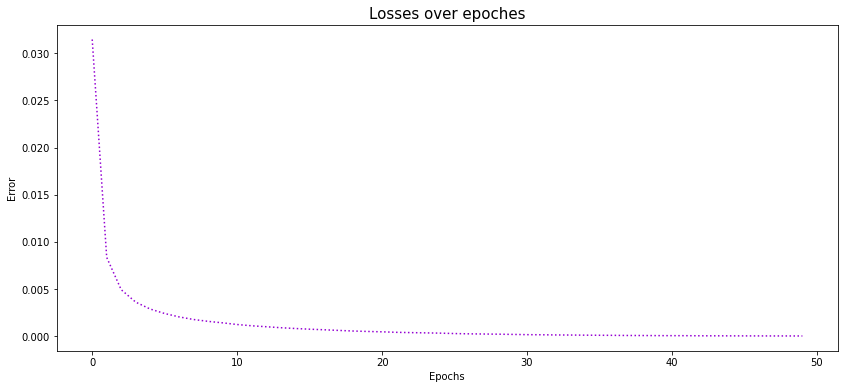

In [22]:
# 전체 loss 에 대한 변화량 시각화
_ = plt.figure(figsize=(14, 6))
_ = plt.plot(losses[:100], c='darkviolet', linestyle=':')

_ = plt.title('Losses over epoches', fontsize=15)
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Error')
_ = plt.show()

# loss는 확 줄어들어서 바닥으로 수렴하는게 아름다운 모습임

## validation set score 확인

In [23]:
with torch.no_grad():
    X_test = torch.tensor(val_dt.reshape(len(val_dt), 1, 28, 28)).float().to(device)
    Y_test = torch.tensor(val_lb).to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

## 따로 ver
# 0.9483999609947205 (재현 됨)

## 같이 ver
# 0.9515999555587769 (이건 재현 됨)

Accuracy: 0.9483999609947205


## test set score 확인

In [25]:
with torch.no_grad():
    X_test = torch.tensor(test_data.reshape(len(test_data), 1, 28, 28)).float().to(device)
    Y_test = torch.tensor(test_labels).to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

## 따로 ver
# 0.9557999968528748 (재현 됨)

## 같이 ver
# 0.9587999582290649
# 0.9581999778747559

Accuracy: 0.9557999968528748


## train validation 같이 하는 ver

In [24]:
losses = []

for epoch in range(CFG['EPOCHS']):
    avg_cost = 0

    for X, Y in train_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y느 ㄴ레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch
    loss = avg_cost / len(train_loader)
    losses.append(loss)
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))
    
    
    with torch.no_grad():
        X_test = torch.tensor(val_dt.reshape(len(val_dt), 1, 28, 28)).float().to(device)
        Y_test = torch.tensor(val_lb).to(device)

        prediction = model(X_test)
        correct_prediction = torch.argmax(prediction, 1) == Y_test
        accuracy = correct_prediction.float().mean()
        print('Accuracy:', accuracy.item())

[Epoch:    1] cost = 2.00940466
Accuracy: 0.6959999799728394
[Epoch:    2] cost = 1.1696173
Accuracy: 0.7699999809265137
[Epoch:    3] cost = 0.853299856
Accuracy: 0.8027999997138977
[Epoch:    4] cost = 0.67885071
Accuracy: 0.8351999521255493
[Epoch:    5] cost = 0.566299498
Accuracy: 0.8535999655723572
[Epoch:    6] cost = 0.480776697
Accuracy: 0.8579999804496765
[Epoch:    7] cost = 0.415599018
Accuracy: 0.863599956035614
[Epoch:    8] cost = 0.369346857
Accuracy: 0.8743999600410461
[Epoch:    9] cost = 0.332278132
Accuracy: 0.8811999559402466
[Epoch:   10] cost = 0.290598959
Accuracy: 0.887999951839447
[Epoch:   11] cost = 0.259059459
Accuracy: 0.8931999802589417
[Epoch:   12] cost = 0.235320032
Accuracy: 0.8999999761581421
[Epoch:   13] cost = 0.2105093
Accuracy: 0.897599995136261
[Epoch:   14] cost = 0.190968305
Accuracy: 0.9047999978065491
[Epoch:   15] cost = 0.173755094
Accuracy: 0.9079999923706055
[Epoch:   16] cost = 0.158956483
Accuracy: 0.91239994764328
[Epoch:   17] cost 

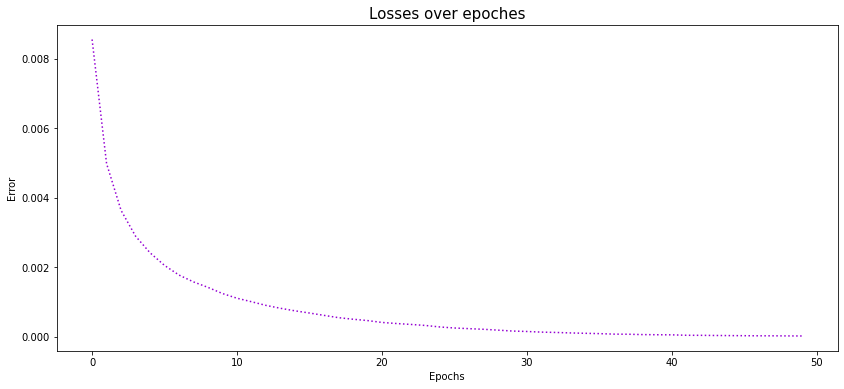

In [25]:
# 전체 loss 에 대한 변화량 시각화
_ = plt.figure(figsize=(14, 6))
_ = plt.plot(losses[:100], c='darkviolet', linestyle=':')

_ = plt.title('Losses over epoches', fontsize=15)
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Error')
_ = plt.show()

# loss는 확 줄어들어서 바닥으로 수렴하는게 아름다운 모습임
## 그림도 재현 됨